<h1> ANALYSIS OF FUNDAMENTAL DATA USING ARIMA  </h1>

In [1]:
import sys
sys.path.append("../getData")
sys.path.append("../../visualization")
sys.path.append("../functions")
sys.path.append("../writer")
import matplotlib.pyplot as plt
from scipy.stats import norm
import itertools
import math
import transformations
import bdStocks
import graficosJupyterNotebook as graficos
import numpy as np
import pandas as pd
import transformationsDataframes
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from  statsmodels.tsa.stattools import arma_order_select_ic  as select_order
import scipy.stats
import statsmodels.stats.diagnostic
import statsmodels.api as sm
import math
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_model import ARMA
from scipy.stats import norm
import math
from datetime import timedelta
import numpy as np
pd.set_option('display.max_rows', None)
import warnings
warnings.filterwarnings("ignore")
import configparser
config = configparser.ConfigParser()
config.read('../../config.properties')
log_dir_excepciones = "../../"+config.get('LOGS_DIR', 'excepciones')
import writer

<h2>Configurable options:</h2>

In [2]:
precios=False
columnas=["netIncome","totalRevenue","stock"]
columnasPrecios=["Adjusted_close","stock"]
tamMinimo=50
column="netIncome"
column2="Adjusted_close"
tam_train=0.8
periodicidad=4
nivel_confianza=0.1
max_lag=5
ponderaciones=[0.6,0.4]
transformar=False
periodoIndice="3M"
if precios:
    periodoIndice="M"
    periodicidad=12
    
    

In [3]:
def contrasteCorrelacionResiduos(serie,diferenciacion,nivel_confianza):
    T=len(serie)-diferenciacion
    varSerie=1/T
    desv=math.sqrt(varSerie)
    nivel=norm.ppf(1-nivel_confianza/2)
    a= abs(serie)/desv<nivel

    return a

class Modelo:
    def __init__(self,modelo,modeloExtendido,significacionP=None,significacionQ=None,significacionPEst=None,significacionQEst=None):
        self.modelo=modelo
        self.modeloExtendido=modeloExtendido
        self.errorTrain=modelo.mse
        self.errorTest=modeloExtendido.mse
        self.aicTrain=modelo.aic
        self.aicTest=modeloExtendido.aic
        self.aicTotal=ponderaciones[0]*self.aicTrain+ponderaciones[1]*self.aicTest
        self.errorTotal=ponderaciones[0]+self.errorTrain*ponderaciones[1]*self.errorTest
        self.significacionP=significacionP
        self.significacionQ=significacionQ
        self.significacionPEst=significacionPEst
        self.significacionQEst=significacionQEst
def crearYProbarModelo(serie_train,serie_test,ordenes=None,ordenesSeason=None,diferenciacion=0,diferenciacionSeason=0,periodo=periodicidad):
    modelo=None
    notSeasonalTrend="c"
    seasonalTrend="c"
    if diferenciacion>0:
        notSeasonalTrend="t"
    if diferenciacionSeason>0:
        seasonalTrend="t"
        if ordenesSeason is None:
            ordenesSeason=(0,0)
        
    if  ordenes is not None:
        ordenes=(ordenes[0],diferenciacion,ordenes[1])
    if  ordenes is not None and ordenesSeason is not None:
        ordenesSeason=(ordenesSeason[0],diferenciacionSeason,ordenesSeason[1],periodo)
    if ordenesSeason is not None:
           ordenesSeason=(ordenesSeason[0],diferenciacionSeason,ordenesSeason[1],periodo)
    if  ordenes is not None and ordenesSeason is not None:   
        s="c"
        if notSeasonalTrend=="t" or  seasonalTrend=="t":
            s="t"
       
        modelo=ARIMA(endog=serie_train,order=ordenes,seasonal_order=ordenesSeason)
    elif ordenes is not None:
        modelo=ARIMA(endog=serie_train,order=ordenes,trend=notSeasonalTrend)
    elif ordenesSeason is not None:
        modelo=ARIMA(endog=serie_train,seasonal_order=ordenesSeason,trend= seasonalTrend)
    if modelo is not None:    
        
        adj=modelo.fit()
        adj2=adj.extend(serie_test.to_numpy())
        
        return adj,adj2

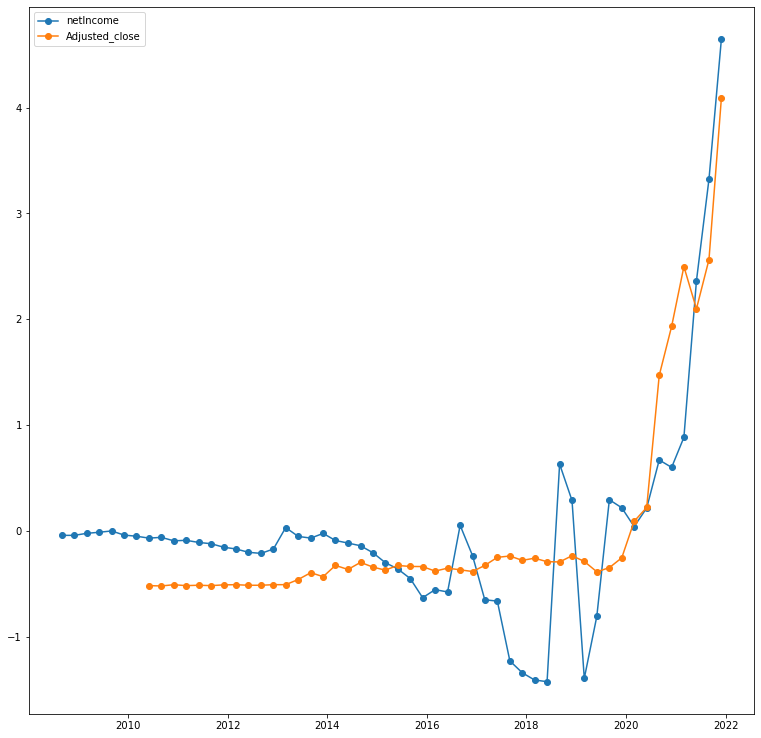

In [4]:
exchange="US"
stock="TSLA"
bd=bdStocks.getData()
data=bd.getDataByStock("fundamental",exchange,stock,bd=True,columnas=[column])
data2=bd.getDataByStock("precios",exchange,stock,bd=True,columnas=[column2])
data2= transformationsDataframes.pasarAMensual(data2)
data=transformationsDataframes.pasarAtrimestres(data)
data3=data.join(data2).fillna(method="ffill")
data3=(data3-data3.mean())/data3.std()
nas=0
nas+=int(data.isna().sum())
fig=plt.figure(figsize=(13,13))
plt.plot(data3.index,data3[column],label=column,marker="o")
plt.plot(data3.index,data3[column2],marker="o",label=column2)
plt.legend()

In [5]:
if precios==True:
    data=data2
    column=column2
data.tail()

,netIncome
fecha,
2020-12-01,2.960000e+08
2021-03-01,4.380000e+08
2021-06-01,1.178000e+09
2021-09-01,1.659000e+09
2021-12-01,2.321000e+09


In [6]:

all_days = pd.date_range(data.index[0],\
                        data.index[-1],freq="3M",normalize=True)
all_days 
all_days=all_days.map(lambda x:x.replace(day=1))

a=data.index[-1]
b=data.iloc[-1]
data=data.reindex(all_days)
if a!=data.index[-1]:
    data.loc[a]=b
print(all_days)
print(data.tail())
data=data/1000000

DatetimeIndex(['2008-09-01', '2008-12-01', '2009-03-01', '2009-06-01',
               '2009-09-01', '2009-12-01', '2010-03-01', '2010-06-01',
               '2010-09-01', '2010-12-01', '2011-03-01', '2011-06-01',
               '2011-09-01', '2011-12-01', '2012-03-01', '2012-06-01',
               '2012-09-01', '2012-12-01', '2013-03-01', '2013-06-01',
               '2013-09-01', '2013-12-01', '2014-03-01', '2014-06-01',
               '2014-09-01', '2014-12-01', '2015-03-01', '2015-06-01',
               '2015-09-01', '2015-12-01', '2016-03-01', '2016-06-01',
               '2016-09-01', '2016-12-01', '2017-03-01', '2017-06-01',
               '2017-09-01', '2017-12-01', '2018-03-01', '2018-06-01',
               '2018-09-01', '2018-12-01', '2019-03-01', '2019-06-01',
               '2019-09-01', '2019-12-01', '2020-03-01', '2020-06-01',
               '2020-09-01', '2020-12-01', '2021-03-01', '2021-06-01',
               '2021-09-01'],
              dtype='datetime64[ns]', freq=None

a
-717.539


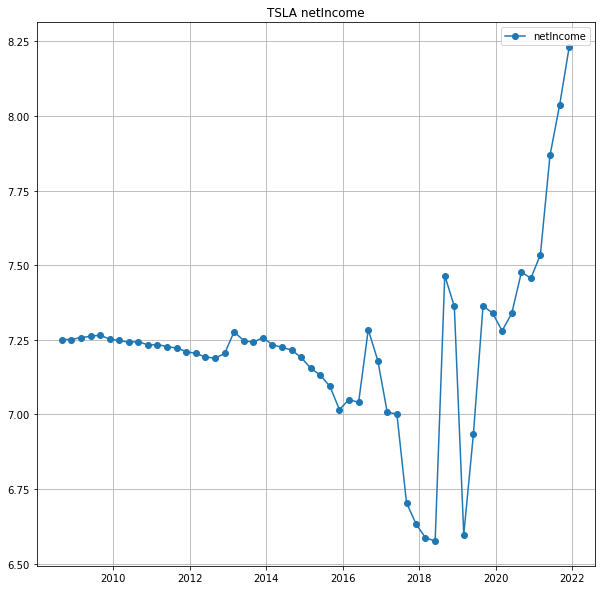

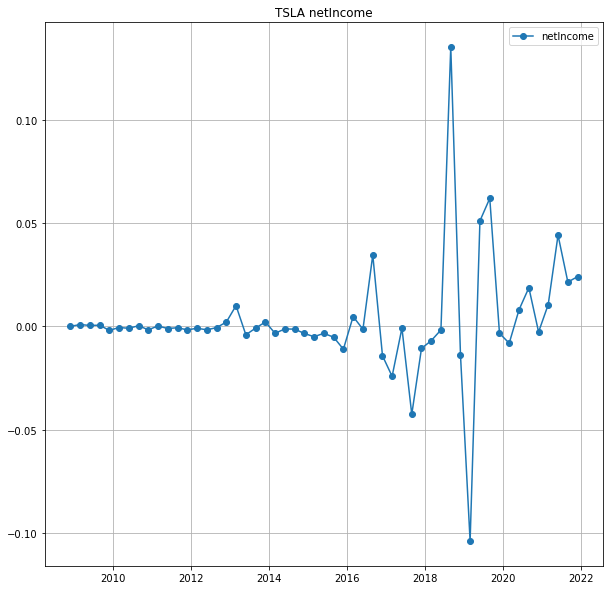

-717.539


DatetimeIndex(['2008-09-01', '2008-12-01', '2009-03-01', '2009-06-01',
               '2009-09-01', '2009-12-01', '2010-03-01', '2010-06-01',
               '2010-09-01', '2010-12-01', '2011-03-01', '2011-06-01',
               '2011-09-01', '2011-12-01', '2012-03-01', '2012-06-01',
               '2012-09-01', '2012-12-01', '2013-03-01', '2013-06-01',
               '2013-09-01', '2013-12-01', '2014-03-01', '2014-06-01',
               '2014-09-01', '2014-12-01', '2015-03-01', '2015-06-01',
               '2015-09-01', '2015-12-01', '2016-03-01', '2016-06-01',
               '2016-09-01', '2016-12-01', '2017-03-01', '2017-06-01',
               '2017-09-01', '2017-12-01', '2018-03-01', '2018-06-01',
               '2018-09-01', '2018-12-01', '2019-03-01', '2019-06-01',
               '2019-09-01', '2019-12-01', '2020-03-01', '2020-06-01',
               '2020-09-01', '2020-12-01', '2021-03-01', '2021-06-01',
               '2021-09-01', '2021-12-01'],
              dtype='datetime64[n

In [7]:
transformar=bool(input())
if transformar:
    minimo=np.min(data)[0]
    if minimo<0:
        print(minimo)
        data=data-minimo*2
    boxcox=transformations.boxcox
    data1=(data).applymap(lambda x:(boxcox(0,x)))
    graficos.linearplot(data1,stock+" "+column,False,column)
    graficos.linearplot(data1.transform(lambda x:x.pct_change()),stock+" "+column,False,column)
    print(minimo)
else:
    data1=data.copy()
data1=transformationsDataframes.pasarAtrimestres(data1)
all_days = pd.date_range(data1.index[0], data1.index[-1]+timedelta(days=40),freq=periodoIndice,normalize=True)
all_days=all_days.map(lambda x:x.replace(day=1))
nas+=len(all_days)-len(data1.index)
data1=data1.reindex(all_days)
serie=data1[column].fillna(method="ffill").dropna()
tam=len(serie)
lim_train=int(tam*tam_train)
serie_train=serie[:lim_train]
serie_test=serie[lim_train:]
all_days

In [8]:
(nas,len(serie))
adf3

NameError: name 'adf3' is not defined

In [9]:
estacional=True
adf=adfuller(serie_train)
adf
posibleEstacionaridad=False
diferenciacion=0
diferenciacionEstacional=0
if adf[1]>nivel_confianza:
    posibleEstacionaridad=True

if posibleEstacionaridad and estacional:
    serie1=pd.Series(serie_train).diff(periodicidad).dropna()
    adf1=adfuller(serie1)
if posibleEstacionaridad:
    serie2=pd.Series(serie_train).diff(1).dropna()
    adf2=adfuller(serie2)

if posibleEstacionaridad and estacional:
    print(adf1,adf2)
    niveles=[0.0001,0.001,0.01,0.05,0.1]
    for idx,nivel in enumerate(niveles[1:]):
        if adf1[1]<nivel:
            diferenciacionEstacional=1
            break
        elif adf2[1]<niveles[idx]:
            diferenciacion=1
            break
    if diferenciacion==0 and diferenciacionEstacional==0:
            serie3=pd.Series(serie1).diff(1).dropna()
            adf3=adfuller(serie3)

            if adf3[0]<adf3[4]["10%"]:
                diferenciacionEstacional=1
                diferenciacion=1
            else:
                serie_train=None
                print("None")
print(diferenciacion, diferenciacionEstacional)   

(0.7383240751579103, 0.9905724660766707, 10, 28, {'1%': -3.6889256286443146, '5%': -2.9719894897959187, '10%': -2.6252957653061224}, -45.517137715690424) (0.45257021406207654, 0.983357936271592, 8, 33, {'1%': -3.6461350877925254, '5%': -2.954126991123355, '10%': -2.6159676124885216}, -48.8576884315501)
1 1


In [10]:
#ver si hay que diferenciar la serie
#en adfuller la nula es que hay raiz unitaria
diferenciacion=1
diferenciacionEstacional=1
estacional=True
paramFuller=5
adf=adfuller(serie_train.diff(4).diff(1).dropna())
#adf=adfuller(serie_train.diff(1).dropna())
#adf=adfuller(serie_train.diff(periodicidad).dropna())
adf


(-2.65053626488159,
 0.08299565529391156,
 9,
 28,
 {'1%': -3.6889256286443146,
  '5%': -2.9719894897959187,
  '10%': -2.6252957653061224},
 -43.148300875905875)

In [11]:
diferenciacion=1

37
0.1643989873053573
[ True False  True False  True False False False False False False False
 False] [ True False  True False  True False  True False  True False  True False
  True]
1.2815515655446004


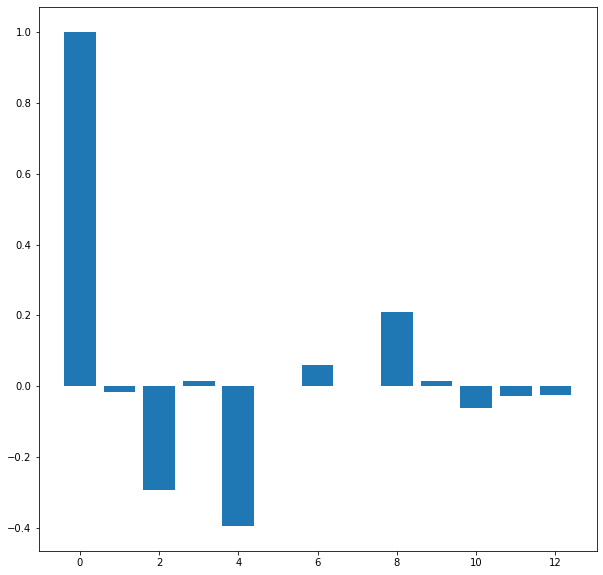

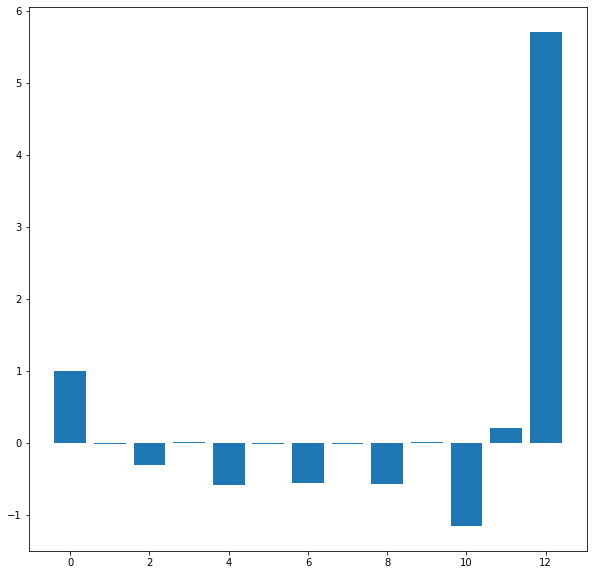

In [12]:
import scipy.stats
import statsmodels.stats.diagnostic
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
serie1=serie_train.copy()
if diferenciacion and  diferenciacionEstacional:
    serie1=serie_train.diff(periodicidad).diff(1)
elif diferenciacion:
    print("hay diferenciacion")
    serie1=serie_train.diff(1)
elif diferenciacionEstacional:
    serie1=serie_train.diff(periodicidad)
serie1=serie1.dropna() 
corr=acf(serie1,nlags=int(len(serie1)/3))
pcorr=pacf(serie1,nlags=int(len(serie1)/3))
nivel=norm.ppf(0.90)
def devolverEstadisticos(corr,pcorr,diferenciacion,serie):
    T=len(serie)-diferenciacion
    print(T)
    varSerie=1/T
    desv=math.sqrt(varSerie)
    print(desv)
    return abs(corr)/desv,abs(pcorr)/desv
estCorr,estPcorr=(devolverEstadisticos(corr,pcorr,diferenciacion,serie1))
print(estCorr>nivel,estPcorr>nivel)
print(nivel)
graficos.correlograma(corr,pcorr)

In [13]:
orden=(1,1)
ordenEst=(0,0)
diferenciacionEstacional=0
diferenciacion=1
adj,adj2=crearYProbarModelo(serie_train,serie_test,ordenes=orden,\
        ordenesSeason=ordenEst,diferenciacion=diferenciacion,diferenciacionSeason=diferenciacionEstacional)

if ordenEst is None:
    ordenEst=(0,0,0)
modelo=Modelo(adj,adj2, orden[0],orden[1],ordenEst[0],ordenEst[1])
print(adj.params)

ar.L1     0.391029
ma.L1    -0.855841
sigma2    0.030931
dtype: float64


In [14]:
print(adj.mse,adj2.mse)
print(adj.aic)


1.252950400977302 0.09749031840774086
-20.129938032121604


-2.6087910039148188 ar.L1     0.391029
ma.L1    -0.855841
sigma2    0.030931
dtype: float64 {'seasonal_periods': 4, 'measurement_error': False, 'time_varying_regression': False, 'simple_differencing': False, 'enforce_stationarity': True, 'enforce_invertibility': True, 'hamilton_representation': False, 'concentrate_scale': False, 'trend_offset': 1, 'order': (1, 1, 1), 'seasonal_order': (0, 0, 0, 4), 'k_diff': 1, 'k_seasonal_diff': 0, 'k_ar': 1, 'k_ma': 1, 'k_seasonal_ar': 0, 'k_seasonal_ma': 0, 'k_ar_params': 1, 'k_ma_params': 1, 'trend': 'n', 'k_trend': 0, 'k_exog': 0, 'mle_regression': False, 'state_regression': False} 1.252950400977302
4.766825708348715e-17
2.3834128541743574e-17
5.754893330234773e-31
[0.54 0.04 0.09 0.1  0.16 0.24 0.34 0.21]


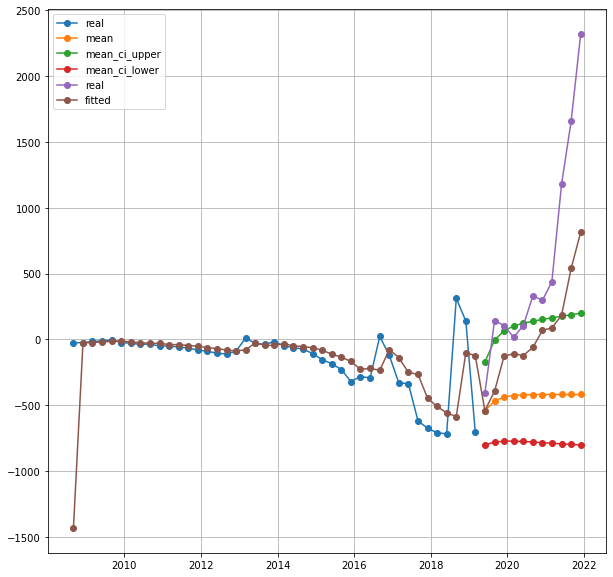

In [15]:

import matplotlib.pyplot as plt
if transformar:
    serie_train1=serie_train.map(lambda x:(math.exp(x)+2*minimo))
    serie_test1=serie_test.map(lambda x:(math.exp(x)+2*minimo))
else:
    serie_train1=serie_train
    serie_test1=serie_test
print(modelo.aicTotal,modelo.modelo.params,modelo.modelo.specification,modelo.modelo.mse)
print(modelo.modelo.test_heteroskedasticity("breakvar",alternative= "two-sided")[0][1])
print(modelo.modelo.test_heteroskedasticity("breakvar",alternative= "increasing")[0][1])
print(modelo.modelo.test_normality(method="jarquebera")[0][1])
u=(modelo.modelo.test_serial_correlation(method="ljungbox"))[0][1]
print(np.around(u,decimals=2))
dataframePred=modelo.modelo.get_forecast(len(serie_test1)).summary_frame()
if transformar:
    dataframePred=dataframePred.applymap(lambda x:(math.exp(x)+2*minimo))
dataframePred["real"]= serie_test1  
primero=modelo.modelo.fittedvalues
segundo=modelo.modeloExtendido.fittedvalues
if transformar:
         primero=primero.map(lambda x:(math.exp(x)+2*minimo))
         segundo=segundo.map(lambda x:(math.exp(x)+2*minimo))

graficos.plot_forecast(serie_train1,dataframePred,pd.concat([primero,segundo]))

In [16]:
data

,netIncome
2008-09-01,1409.580
2008-12-01,1409.580
2009-03-01,1419.062
2009-06-01,1424.211
2009-09-01,1430.463
2009-12-01,1410.836
2010-03-01,1405.559
2010-06-01,1396.561
2010-09-01,1400.143
2010-12-01,1383.720
